In [14]:
import sys
import os

repo_root = os.path.abspath(os.path.join(os.path.dirname(os.getcwd())))
sys.path.append(repo_root)

print(repo_root)

/home/jackyeung99/classes/class_financial-econometrics


In [15]:
import matplotlib.pyplot as plt
import math 
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents as UCM
from statsmodels.tsa.statespace.mlemodel import MLEModel

In [16]:
plt.style.use("../styler.mplstyle") 

In [17]:
data = ['CPIAUCSL', 'GDPC1', 'CNP16OV', 'FEDFUNDS', 'LNS12000001', 'LNS12000002']

In [18]:
df = pdr.DataReader(
    data,
    "fred",
    start="1980-01-01",
    end="2025-07-01"
).astype(float).reset_index()

In [19]:
df['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift())
df['INF_demeaned'] = df['INF'] - df['INF'].mean()
df = df.rename(columns = {'LNS12000001': 'male_unemployment', 'LNS12000002': 'female_unemployment'})

### Question 1

Text(0, 0.5, '$\\Delta$ INF')

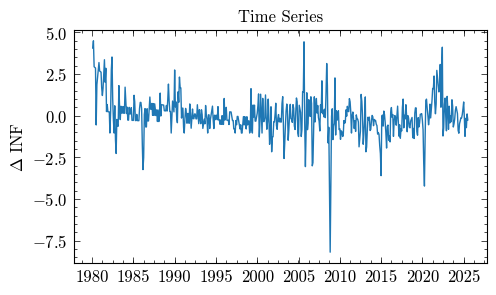

In [20]:
plt.plot(df['DATE'], df['INF_demeaned'])
plt.title("Time Series")
# plt.xlabel("Time")
plt.ylabel("$\Delta$ INF")


In [21]:
p_vals = [0, 1, 2, 3]
q_vals = [0, 1, 2, 3]

In [22]:
models = {}
model_summaries = []

In [23]:
for p in p_vals:  
    for q in q_vals:

        if p == q and p == 0:
            continue
        

        model = ARIMA(df['INF_demeaned'], order=(p, 0, q))
        model_fit = model.fit()

        model_summaries.append({
            'p' : p, 
            'q': q,
            'AIC': model_fit.aic,
            'BIC': model_fit.bic,
            'log_like': model_fit.llf
        })
        models[f'{p}{q}'] = model_fit
        
    

        

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [24]:
pd.DataFrame(model_summaries)

,p,q,AIC,BIC,log_like
0,0,1,1542.600586,1555.513932,-768.300293
1,0,2,1527.010672,1544.228467,-759.505336
2,0,3,1526.519965,1548.042209,-758.259982
3,1,0,1525.401504,1538.314850,-759.700752
4,1,1,1521.290316,1538.508112,-756.645158
5,1,2,1497.381656,1518.903900,-743.690828
6,1,3,1498.163687,1523.990379,-743.081843
7,2,0,1523.986330,1541.204126,-757.993165
8,2,1,1521.285486,1542.807730,-755.642743
9,2,2,1498.370430,1524.197123,-743.185215


In [25]:
summary_df = pd.DataFrame(model_summaries).sort_values('AIC').reset_index(drop=True)
topN = 2 
top_rows = summary_df.head(topN)
top_rows[['p', 'q', 'AIC']]

,p,q,AIC
0,1,2,1497.381656
1,1,3,1498.163687


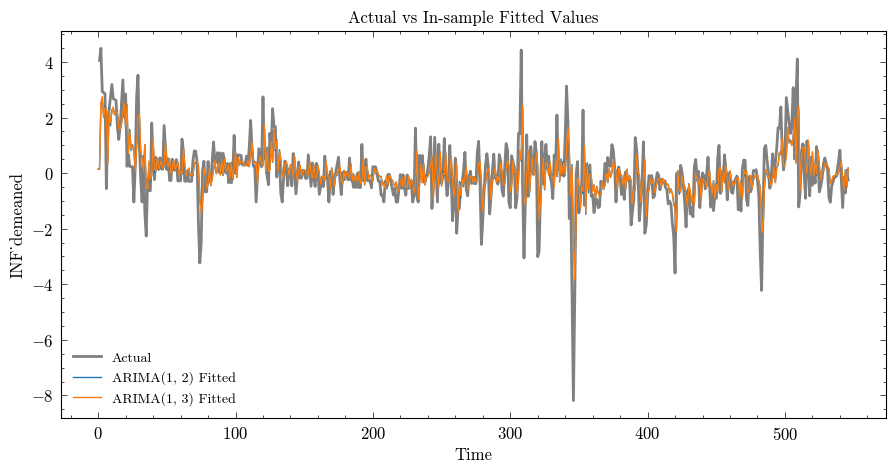

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['INF_demeaned'], label='Actual', linewidth=2, color='grey')

for i, (_, row) in enumerate(top_rows.iterrows()):
    p = int(row['p'])
    q = int(row['q'])
    
    model_fit = models[f'{p}{q}']  
    ax.plot(
        model_fit.fittedvalues,
        label=f'ARIMA({p}, {q}) Fitted',
        # color=colors[i]
    )

# Format the plot
ax.set_title('Actual vs In-sample Fitted Values')
ax.set_xlabel('Time')
ax.set_ylabel('INF_demeaned')
ax.legend()

plt.savefig('../Figures/Assignment06/aic.png', dpi = 300)
plt.show()

In [27]:
summary_df = pd.DataFrame(model_summaries).sort_values('BIC').reset_index(drop=True)

topN = 2 
top_rows = summary_df.head(topN)
top_rows[['p', 'q', 'BIC']]

,p,q,BIC
0,1,2,1518.903900
1,1,3,1523.990379


In [28]:
summary_df

,p,q,AIC,BIC,log_like
0,1,2,1497.381656,1518.903900,-743.690828
1,1,3,1498.163687,1523.990379,-743.081843
2,2,2,1498.370430,1524.197123,-743.185215
3,3,1,1498.402218,1524.228911,-743.201109
4,3,2,1499.532644,1529.663786,-742.766322
5,2,3,1499.582085,1529.713227,-742.791043
6,3,0,1513.408271,1534.930515,-751.704136
7,3,3,1501.318088,1535.753678,-742.659044
8,1,0,1525.401504,1538.314850,-759.700752
9,1,1,1521.290316,1538.508112,-756.645158


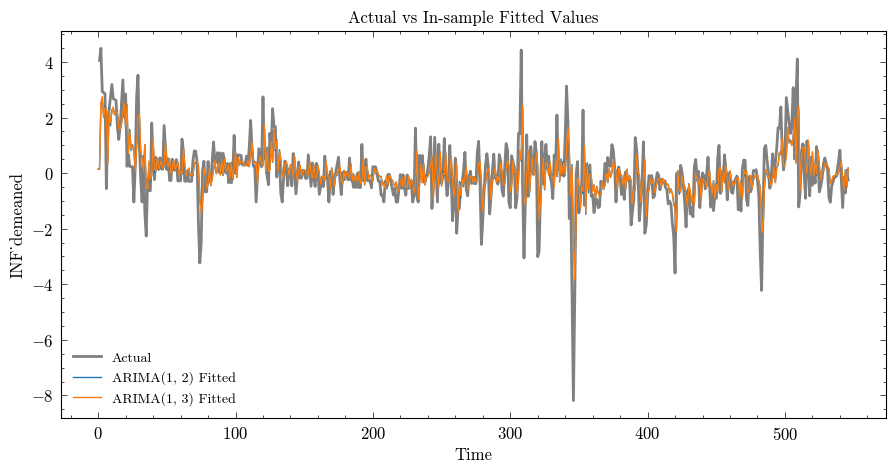

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df['INF_demeaned'], label='Actual', linewidth=2, color='grey')

for i, (_, row) in enumerate(top_rows.iterrows()):
    p = int(row['p'])
    q = int(row['q'])
    
    model_fit = models[f'{p}{q}']  
    ax.plot(
        model_fit.fittedvalues,
        label=f'ARIMA({p}, {q}) Fitted',
        # color=colors[i]
    )

# Format the plot
ax.set_title('Actual vs In-sample Fitted Values')
ax.set_xlabel('Time')
ax.set_ylabel('INF_demeaned')
ax.legend()

plt.savefig('../Figures/Assignment06/bic.png', dpi = 300)
plt.show()

### Question 2

In [30]:
def state_space(time_series):
    model = UCM(time_series, level='local level', irregular=True)
    res = model.fit(disp=False)
    print(res.summary())


    x_filt = res.filtered_state[0]         
    x_smooth = res.smoothed_state[0]        
    u_filt = time_series.values - x_filt
    u_smooth = time_series.values - x_smooth


    return x_filt, x_smooth, u_filt, u_smooth
    

In [31]:
x_filt, x_smooth, u_filt, u_smooth = state_space(df['male_unemployment'])

                        Unobserved Components Results                         
Dep. Variable:      male_unemployment   No. Observations:                  547
Model:                    local level   Log Likelihood               -4198.744
Date:                Tue, 16 Dec 2025   AIC                           8401.487
Time:                        12:04:24   BIC                           8410.092
Sample:                             0   HQIC                          8404.851
                                - 547                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   191.4721   3644.348      0.053      0.958   -6951.318    7334.262
sigma2.level      2.792e+05   6368.031     43.846      0.000    2.67e+05    2.92e+05
Ljung-Box (L1) (Q):         

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


In [32]:
dates = df['DATE']

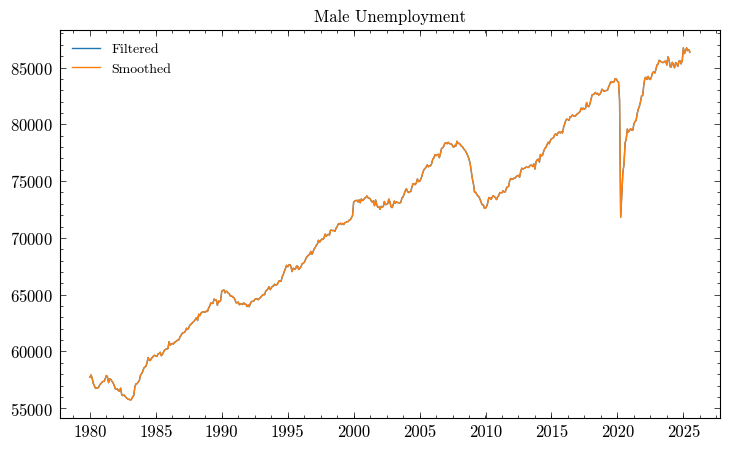

In [33]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Male Unemployment')
plt.plot(dates, x_filt, label = 'Filtered')
plt.plot(dates, x_smooth, label = 'Smoothed')
plt.legend()

plt.savefig('../Figures/Assignment06/male_unemployment.png', dpi = 300)
plt.show()

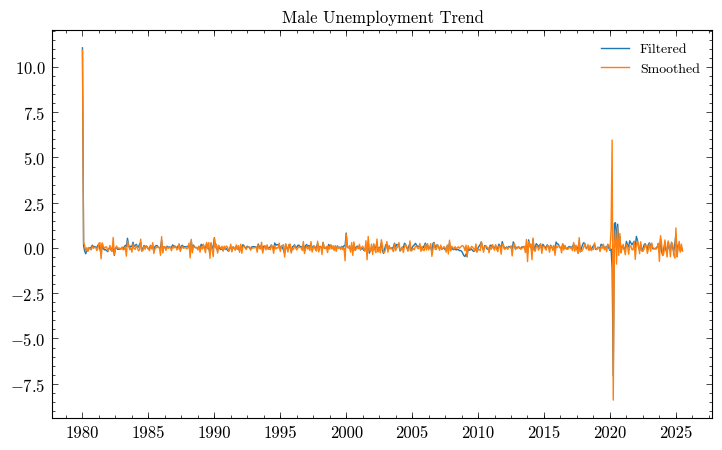

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Male Unemployment Trend')
plt.plot(dates, u_filt, label = 'Filtered')
plt.plot(dates, u_smooth, label = 'Smoothed')
plt.savefig('../Figures/Assignment06/male_unemployment_cycle.png', dpi = 300)
plt.legend()


In [35]:
female_x_filt, female_x_smooth, female_u_filt, female_u_smooth = state_space(df['female_unemployment'])

                         Unobserved Components Results                         
Dep. Variable:     female_unemployment   No. Observations:                  547
Model:                     local level   Log Likelihood               -4255.925
Date:                 Tue, 16 Dec 2025   AIC                           8515.849
Time:                         12:04:25   BIC                           8524.454
Sample:                              0   HQIC                          8519.213
                                 - 547                                         
Covariance Type:                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1032.0067   4870.425      0.212      0.832   -8513.851    1.06e+04
sigma2.level      3.447e+05   8455.379     40.767      0.000    3.28e+05    3.61e+05
Ljung-Box (L1) (Q): 

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


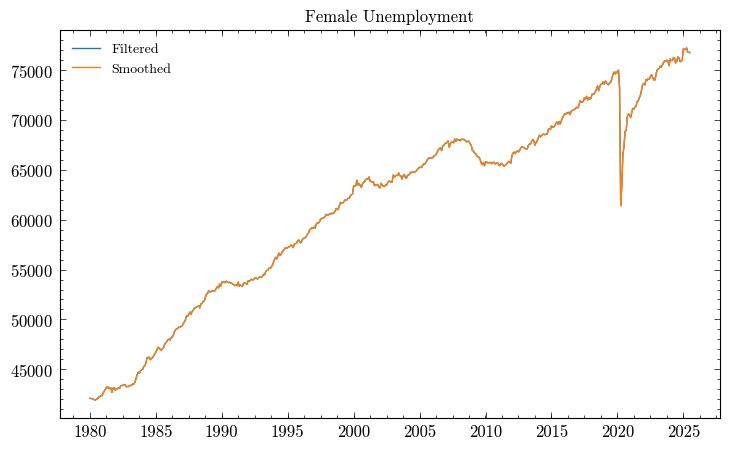

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Female Unemployment')
plt.plot(dates, female_x_filt, label = 'Filtered')
plt.plot(dates, female_x_smooth, label = 'Smoothed')
plt.legend()

plt.savefig('../Figures/Assignment06/female_unemployment.png', dpi = 300)
plt.show()

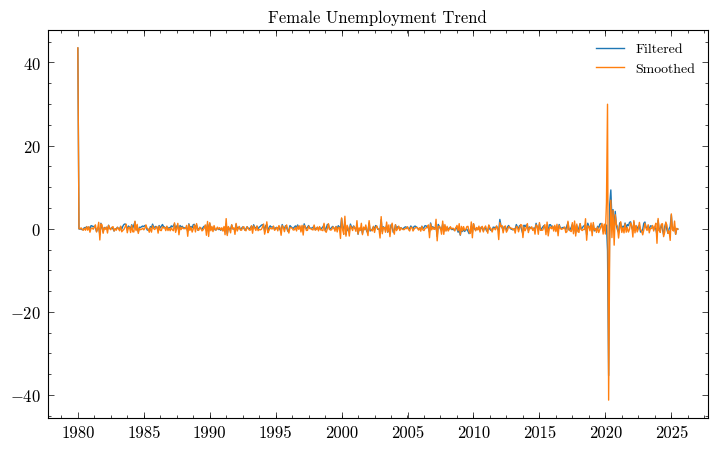

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Female Unemployment Trend')
plt.plot(dates, female_u_filt, label = 'Filtered')
plt.plot(dates, female_u_smooth, label = 'Smoothed')
plt.legend()

plt.savefig('../Figures/Assignment06/female_unemployment_cycle.png', dpi = 300)
plt.show()

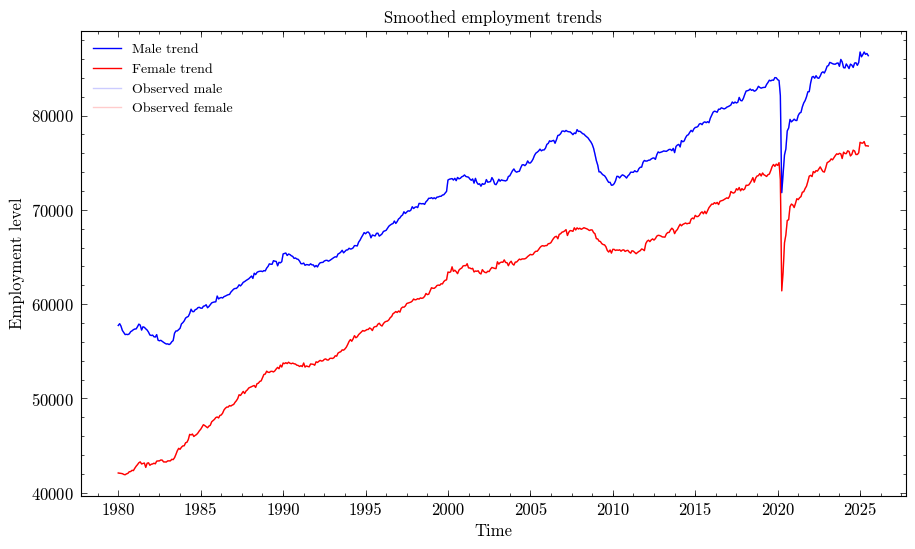

In [38]:
plt.figure(figsize=(10,6))
plt.plot(dates, x_smooth, label='Male trend', color='blue')
plt.plot(dates, female_x_smooth, label='Female trend', color='red')
plt.plot(dates, df['male_unemployment'], color='blue', alpha=0.2, label='Observed male')
plt.plot(dates, df['female_unemployment'], color='red', alpha=0.2, label='Observed female')
plt.legend()
plt.title("Smoothed employment trends")
plt.xlabel("Time")
plt.ylabel("Employment level")

plt.savefig('../Figures/Assignment06/unemployment_cycle.png', dpi = 300)
plt.show()

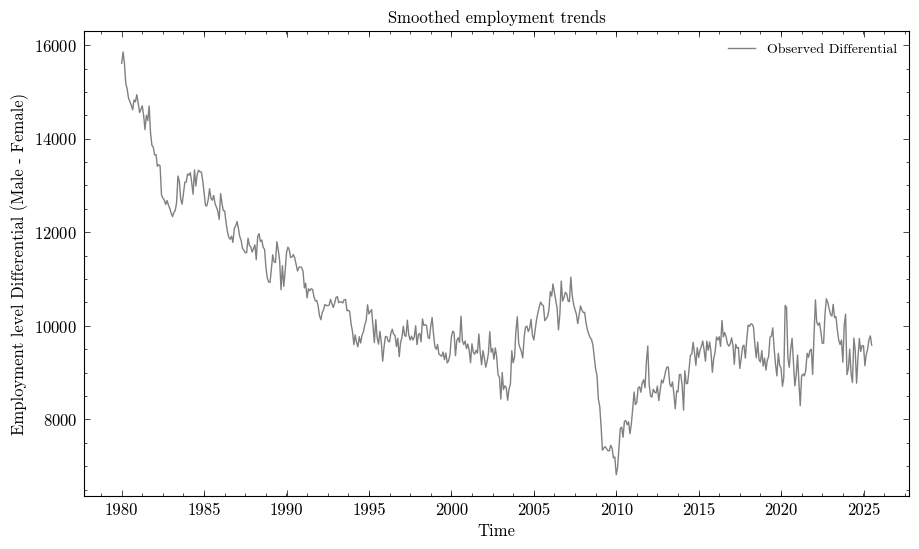

In [39]:
plt.figure(figsize=(10,6))
plt.plot(dates, df['male_unemployment'] - df['female_unemployment'], color='grey', label='Observed Differential')
plt.legend()
plt.title("Smoothed employment trends")
plt.xlabel("Time")
plt.ylabel("Employment level Differential (Male - Female)")

plt.savefig('../Figures/Assignment06/unemployment_diff.png', dpi = 300)
plt.show()

Overall correlation: -0.011


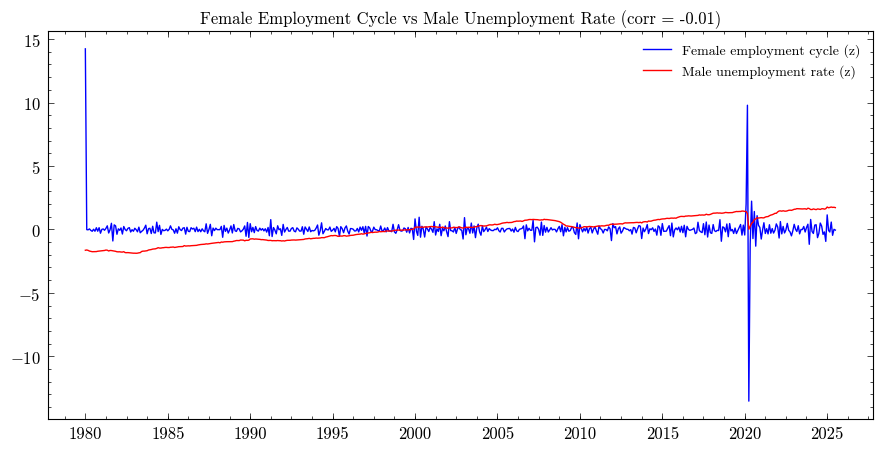

In [40]:


aligned = pd.concat([pd.Series(female_u_smooth), df['male_unemployment']], axis=1).dropna()
aligned.columns = ['Female_cycle', 'Male_unemp']

# Compute correlation
corr = aligned['Female_cycle'].corr(aligned['Male_unemp'])
print(f"Overall correlation: {corr:.3f}")

# Normalize (z-score) for plotting comparably
z_f = (aligned['Female_cycle'] - aligned['Female_cycle'].mean()) / aligned['Female_cycle'].std()
z_m = (aligned['Male_unemp'] - aligned['Male_unemp'].mean()) / aligned['Male_unemp'].std()

plt.figure(figsize=(10,5))
plt.plot(dates, z_f, label='Female employment cycle (z)', color='blue')
plt.plot(dates, z_m, label='Male unemployment rate (z)', color='red')
plt.title(f'Female Employment Cycle vs Male Unemployment Rate (corr = {corr:.2f})')
plt.legend()

plt.savefig('../Figures/Assignment06/unemployment_corr.png', dpi = 300)
plt.show()

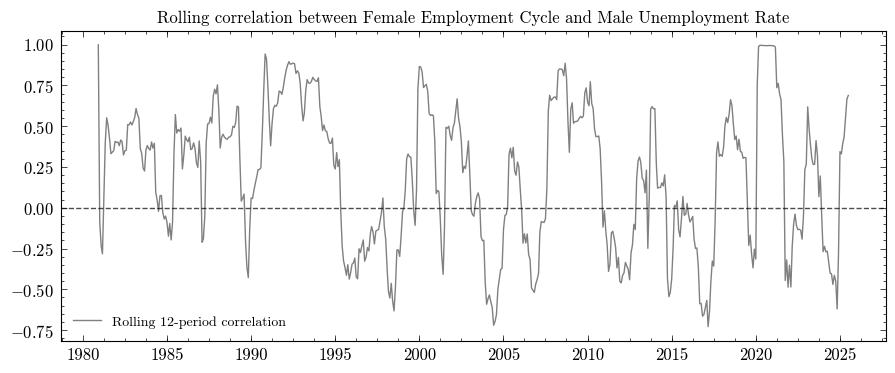

In [41]:
window = 12
aligned['Male_Cycle'] =  u_smooth
rolling_corr = aligned['Female_cycle'].rolling(window).corr(aligned['Male_Cycle'])

plt.figure(figsize=(10,4))
plt.plot(dates, rolling_corr, label=f'Rolling {window}-period correlation', color='grey')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.title('Rolling correlation between Female Employment Cycle and Male Unemployment Rate')
plt.legend()

plt.savefig('../Figures/Assignment06/unemployment_rolling_corr.png', dpi = 300)
plt.show()

### Question 3 

In [42]:
df_clean = df[['DATE', 'FEDFUNDS', 'INF']].dropna()
dates = df_clean['DATE']

In [43]:
def estimate_ex_ante(df_subset, date_col='DATE', int_col='FEDFUNDS', inf_col='INF', demean=True):
    """
    Fits r_t = i_t - pi_t, with latent AR(1) ex-ante rate r_t^e.
    Returns a dict of aligned Series and the statsmodels result object.
    """
    df_ = df_subset[[date_col, int_col, inf_col]].copy()
    df_[date_col] = pd.to_datetime(df_[date_col])
    df_ = df_.dropna()

    r = df_[int_col] - df_[inf_col]     # ex-post real rate
    if demean:
        r = r - r.mean()

    model = UCM(r, autoregressive=1, irregular=True)
    res = model.fit(disp=False)

    # states
    r_e_filt   = pd.Series(res.filtered_state[0], index=r.index, name='r_e_filtered')
    r_e_smooth = pd.Series(res.smoothed_state[0], index=r.index, name='r_e_smoothed')

    # measurement errors (optional; not plotted here)
    u_filt   = r - r_e_filt
    u_smooth = r - r_e_smooth

    out = {
        'dates': df_.loc[r.index, date_col],
        'r': r.rename('r_ex_post'),
        'r_e_filt': r_e_filt,
        'r_e_smooth': r_e_smooth,
        'u_filt': u_filt,
        'u_smooth': u_smooth,
        'int': df_.loc[r.index, int_col],
        'inf': df_.loc[r.index, inf_col],
        'beta_hat': float(res.params.get('autoregressive.L1', np.nan)),
        'res': res
    }
    return out

# ---------- Plot 1: ex-ante vs ex-post real rate ----------
def plot_real_rates(est, vertical_marks=None, title_suffix=''):
    """
    est: dict from estimate_ex_ante
    vertical_marks: list of 'YYYY-MM-DD' strings for vertical lines (optional)
    """
    dates = est['dates']
    plt.figure(figsize=(10,5))
    plt.plot(dates, est['r'], label='Ex-post real rate $r_t$', alpha=0.55)
    plt.plot(dates, est['r_e_filt'], label='Filtered ex-ante $r_t^e$', linestyle='--')
    plt.plot(dates, est['r_e_smooth'], label='Smoothed ex-ante $r_t^e$')

    if vertical_marks:
        for d in vertical_marks:
            d_ = pd.to_datetime(d)
            plt.axvline(d_, linewidth=1, alpha=0.6)

    beta = est['beta_hat']
    ttl = "Ex-ante vs Ex-post Real Interest Rates"
    if title_suffix:
        ttl += f" — {title_suffix}"
    plt.title(ttl + (f" (β̂ = {beta:.2f})" if pd.notna(beta) else ""))
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
    plt.show()

# ---------- Plot 2: actual vs expected inflation ----------
def plot_inflation_actual_vs_expected(est, use='smooth', vertical_marks=None, title_suffix=''):
    """
    use: 'smooth' or 'filter' to choose which r_t^e to convert into expected inflation.
    Expected inflation: pi_t^e = i_t - r_t^e
    """
    dates = est['dates']
    r_e = est['r_e_smooth'] if use == 'smooth' else est['r_e_filt']
    pi_exp = (est['int'] - r_e).rename('pi_exp')

    plt.figure(figsize=(10,5))
    plt.plot(dates, est['inf'], label='Actual inflation $\\pi_t$', alpha=0.7)
    plt.plot(dates, pi_exp, label=f'Expected inflation $\\pi_t^e$ ({use})')

    if vertical_marks:
        for d in vertical_marks:
            d_ = pd.to_datetime(d)
            plt.axvline(d_, linewidth=1, alpha=0.6)

    ttl = "Actual vs Expected Inflation"
    if title_suffix:
        ttl += f" — {title_suffix}"
    plt.title(ttl)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)
    plt.show()

# ---------- Helpers for slicing by assignment windows ----------
def slice_by_dates(df, start, end, date_col='DATE'):
    """Inclusive slice by calendar dates."""
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col])
    mask = (d[date_col] >= pd.to_datetime(start)) & (d[date_col] <= pd.to_datetime(end))
    return d.loc[mask]

/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/tmp/ipykernel_1612/2679433340.py:62: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:63: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


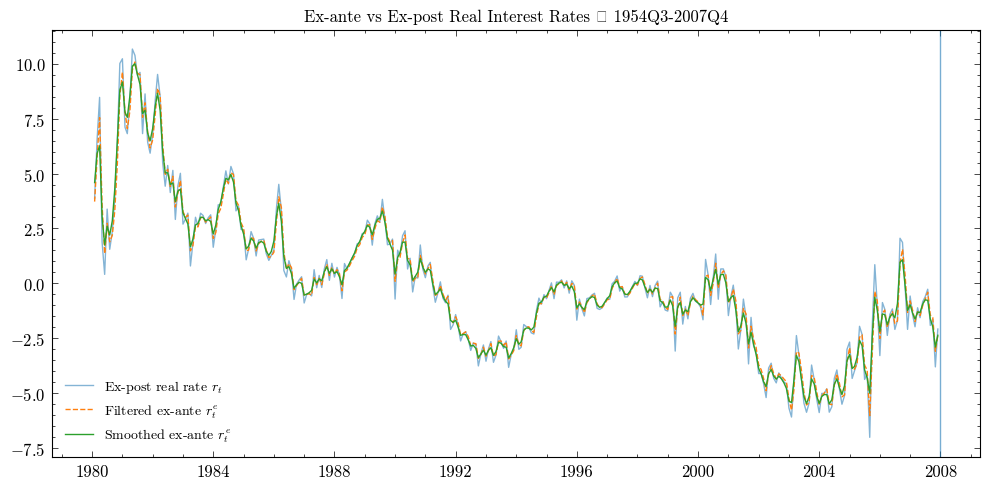

/tmp/ipykernel_1612/2679433340.py:90: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:91: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)


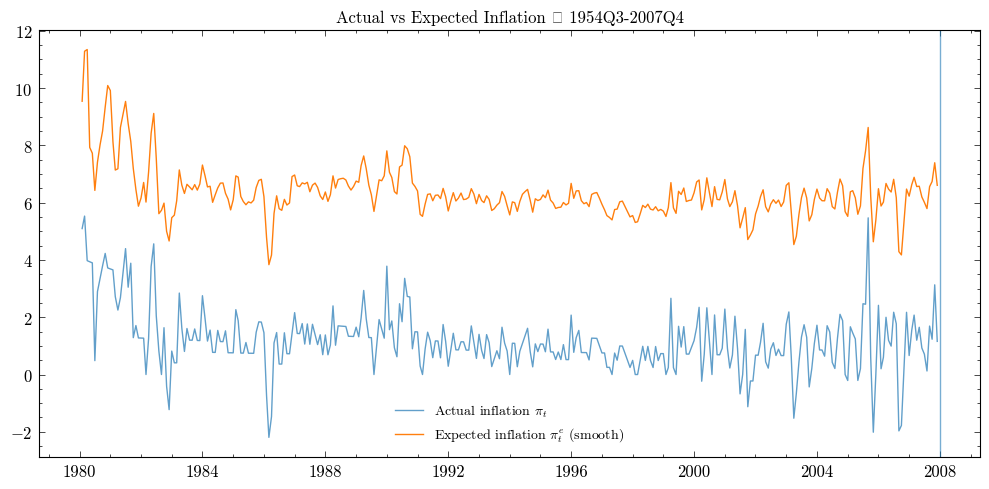

In [44]:
# (a) 1954Q3–2007Q4
df_a = slice_by_dates(df, '1954-07-01', '2007-12-31')
est_a = estimate_ex_ante(df_a)
plot_real_rates(est_a, vertical_marks=['2007-12-31'], title_suffix='1954Q3-2007Q4')
plot_inflation_actual_vs_expected(est_a, use='smooth', vertical_marks=['2007-12-31'], title_suffix='1954Q3-2007Q4')



/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/tmp/ipykernel_1612/2679433340.py:62: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:62: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:63: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
/tmp/ipykernel_1612/2679433340.py:63: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-pack

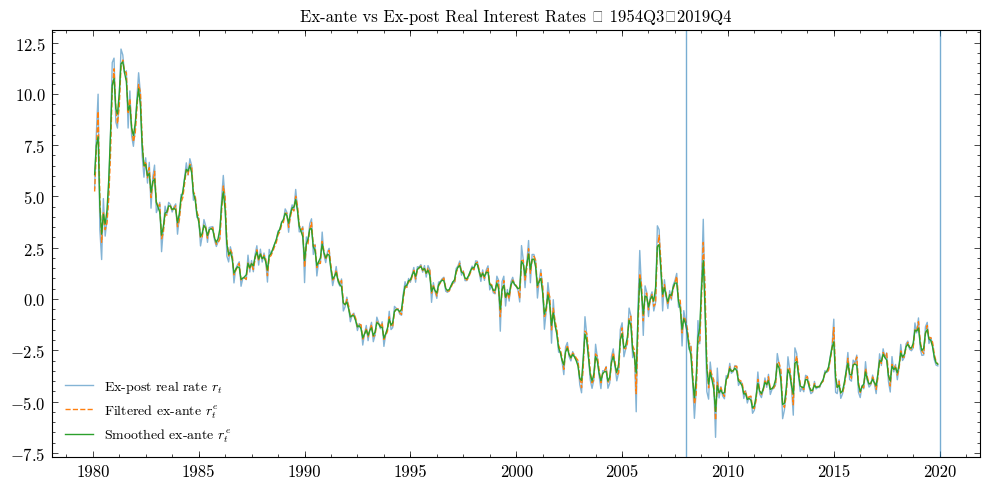

/tmp/ipykernel_1612/2679433340.py:90: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:90: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:91: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)
/tmp/ipykernel_1612/2679433340.py:91: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)


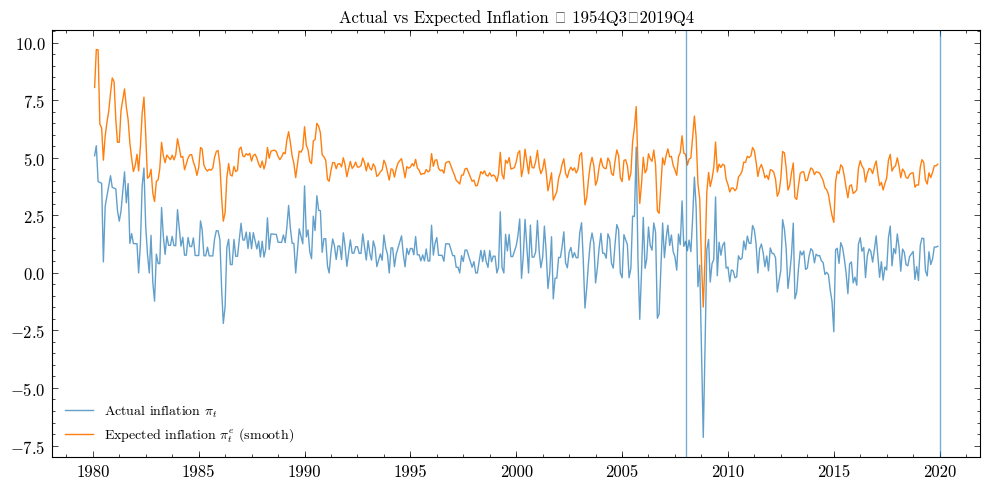

In [45]:
# (c) 1954Q3–2019Q4
df_c = slice_by_dates(df, '1954-07-01', '2019-12-31')
est_c = estimate_ex_ante(df_c)
plot_real_rates(est_c, vertical_marks=['2007-12-31','2019-12-31'], title_suffix='1954Q3–2019Q4')
plot_inflation_actual_vs_expected(est_c, use='smooth', vertical_marks=['2007-12-31','2019-12-31'], title_suffix='1954Q3–2019Q4')


/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/tmp/ipykernel_1612/2679433340.py:62: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:62: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:63: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
/tmp/ipykernel_1612/2679433340.py:63: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}.png', dpi = 300)
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-pack

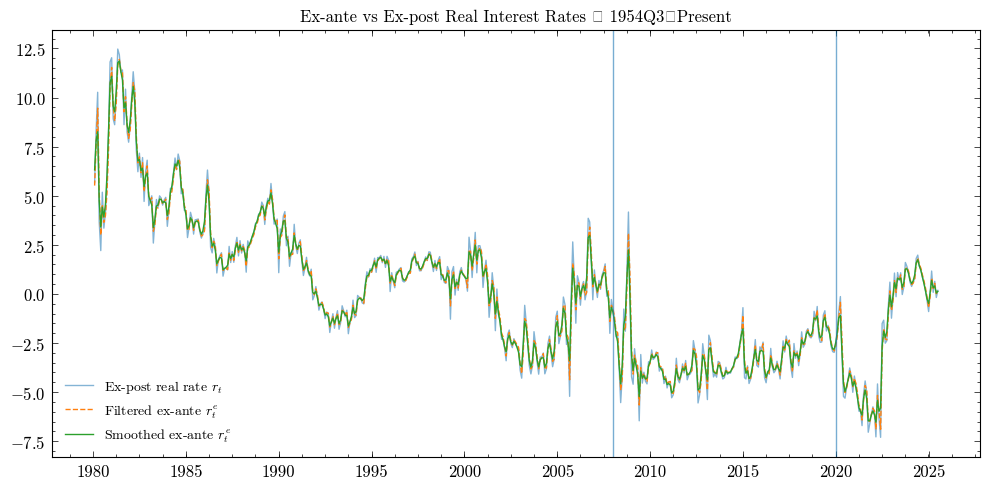

/tmp/ipykernel_1612/2679433340.py:90: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:90: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.tight_layout()
/tmp/ipykernel_1612/2679433340.py:91: UserWarning: Glyph 8212 (\N{EM DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)
/tmp/ipykernel_1612/2679433340.py:91: UserWarning: Glyph 8211 (\N{EN DASH}) missing from font(s) cmr10.
  plt.savefig(f'../Figures/Assignment06/{ttl}_inf.png', dpi = 300)


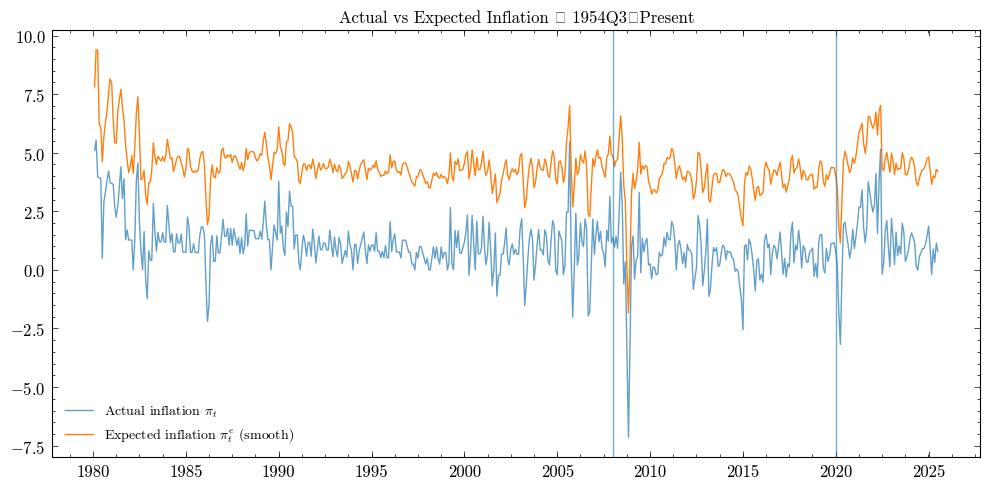

In [46]:

# (d) 1954Q3–present
df_d = slice_by_dates(df, '1954-07-01', '2100-01-01')
est_d = estimate_ex_ante(df_d)
plot_real_rates(est_d, vertical_marks=['2007-12-31','2019-12-31'], title_suffix='1954Q3–Present')
plot_inflation_actual_vs_expected(est_d, use='smooth', vertical_marks=['2007-12-31','2019-12-31'], title_suffix='1954Q3–Present')

### Question 4

In [105]:
data = [
    'GDPC1',
    'DTB3',
    'CPIAUCSL',
    'M318501Q027NBEA',
    'M2SL'
    ]

In [106]:
df = pdr.DataReader(
    data,
    "fred",
    start="1980-01-01",
    end="2025-07-01"
).astype(float).reset_index().set_index('DATE')

In [107]:
monthly_vars = ["DTB3", "CPIAUCSL", "M2SL"]
quarterly_vars = ["GDPC1", "M318501Q027NBEA"]

monthly_q = df[monthly_vars].resample("QE").mean()
quarterly_q = df[quarterly_vars].resample("QE").last()

df_q = pd.concat([monthly_q, quarterly_q], axis=1)

In [108]:
df_q

,DTB3,CPIAUCSL,M2SL,GDPC1,M318501Q027NBEA
DATE,,,,,
1980-03-31,13.345968,79.033333,1492.366667,7341.557,-26.894
1980-06-30,9.618254,81.700000,1514.566667,7190.289,8.073
1980-09-30,9.135469,83.233333,1560.333333,7181.743,-15.656
1980-12-31,13.604918,85.566667,1593.466667,7315.677,-33.555
1981-03-31,14.352951,87.933333,1620.733333,7459.022,-32.053
...,...,...,...,...,...
2024-09-30,4.997969,314.182667,21170.900000,23478.570,NaN
2024-12-31,4.400968,316.538667,21380.166667,23586.542,NaN
2025-03-31,4.208197,319.492000,21564.566667,23548.210,NaN


In [109]:
# df_q['INF'] = 400 * np.log(df['CPIAUCSL']/ df['CPIAUCSL'].shift())



df_q["y"] = 100 * df_q["M2SL"].diff()

df_q["const"] = 1.0
df_q["di_lag"] = df_q["DTB3"].diff().shift()
df_q['cpi_lag'] = df_q['CPIAUCSL'].diff().shift()
df_q["surplus_lag"] = (df_q["M318501Q027NBEA"] / df_q['GDPC1']).shift()
df_q["y_lag"] = df_q["y"].shift()
# Constant

df_q

,DTB3,CPIAUCSL,M2SL,GDPC1,M318501Q027NBEA,y,const,di_lag,cpi_lag,surplus_lag,y_lag
DATE,,,,,,,,,,,
1980-03-31,13.345968,79.033333,1492.366667,7341.557,-26.894,NaN,1.0,NaN,NaN,NaN,NaN
1980-06-30,9.618254,81.700000,1514.566667,7190.289,8.073,2220.000000,1.0,NaN,NaN,-0.003663,NaN
1980-09-30,9.135469,83.233333,1560.333333,7181.743,-15.656,4576.666667,1.0,-3.727714,2.666667,0.001123,2220.000000
1980-12-31,13.604918,85.566667,1593.466667,7315.677,-33.555,3313.333333,1.0,-0.482785,1.533333,-0.002180,4576.666667
1981-03-31,14.352951,87.933333,1620.733333,7459.022,-32.053,2726.666667,1.0,4.469449,2.333333,-0.004587,3313.333333
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,4.997969,314.182667,21170.900000,23478.570,NaN,18046.666667,1.0,0.012256,2.121333,NaN,14540.000000
2024-12-31,4.400968,316.538667,21380.166667,23586.542,NaN,20926.666667,1.0,-0.248222,1.087000,NaN,18046.666667
2025-03-31,4.208197,319.492000,21564.566667,23548.210,NaN,18440.000000,1.0,-0.597001,2.356000,NaN,20926.666667


In [113]:
X = df_q[[
    "const",
    "di_lag",
    "cpi_lag",
    "surplus_lag",
    "y_lag"
]]

y = df_q["y"]

# Drop initial NaNs caused by differencing/lags
reg_data = pd.concat([y, X], axis=1).dropna()

y = reg_data["y"]
X = reg_data[X.columns]

In [114]:
# Up to 2007Q4
y_2007 = y.loc[: "2007-12-31"]
X_2007 = X.loc[: "2007-12-31"]

# Up to 2019Q4
y_2019 = y.loc[: "2019-12-31"]
X_2019 = X.loc[: "2019-12-31"]

# Full sample (Covid included)
y_full = y
X_full = X

In [154]:

class TVCRegression(MLEModel):
    """
    Time-varying coefficient regression:

        y_t = x_t' beta_t + e_t,    e_t ~ N(0, R)
        beta_t = beta_{t-1} + v_t,  v_t ~ N(0, Q)

    Q is diagonal (one variance per coefficient).
    """

    def __init__(self, endog, exog):
        if exog is None:
            raise ValueError("exog is None. You must pass X (T×k) into TVCRegression(endog, exog).")

        # Convert to arrays
        endog = np.asarray(endog).squeeze()
        exog = np.asarray(exog)

        # Force exog to be 2D: (T, k)
        if exog.ndim == 1:
            exog = exog.reshape(-1, 1)

        if endog.ndim != 1:
            raise ValueError(f"endog must be 1D (T,), got shape {endog.shape}")
        if exog.shape[0] != endog.shape[0]:
            raise ValueError(f"exog and endog must have same T. Got endog {endog.shape[0]}, exog {exog.shape[0]}")

        self.exog = exog
        self.k = exog.shape[1]   # number of time-varying coefficients
        T = exog.shape[0]

        super().__init__(endog=endog, k_states=self.k, k_posdef=self.k,
                         initialization="approximate_diffuse")

        # Time-varying design matrix Z_t = x_t'
        # statsmodels expects design shaped (k_endog, k_states, nobs) = (1, k, T)
        self.ssm["design"] = exog.T[None, :, :]   # (1, k, T)

        # State equation beta_t = beta_{t-1} + v_t
        self.ssm["transition"] = np.eye(self.k)
        self.ssm["selection"]  = np.eye(self.k)

        # Initialize covariances (overwritten in update)
        self.ssm["state_cov"] = np.eye(self.k)
        self.ssm["obs_cov"]   = np.array([[1.0]])


    @property
    def start_params(self):
        # parameters are unconstrained; we will map -> positive with softplus
        # good starting points:
        endog_var = np.nanvar(self.endog)
        R0 = max(endog_var * 0.1, 1e-4)
        q0 = np.full(self.k, 1e-3)  # small state noise
        # inverse softplus for starts
        def inv_softplus(x):
            return np.log(np.expm1(x))
        return np.r_[inv_softplus(R0), inv_softplus(q0)]

    def transform_params(self, unconstrained):
        # softplus: positive, smooth, avoids exp overflow
        # softplus(z) = log(1 + exp(z))
        z = np.asarray(unconstrained, dtype=float)
        return np.log1p(np.exp(z))

    def untransform_params(self, constrained):
        # inverse softplus, safe for tiny values
        # inv(y) = log(exp(y) - 1)
        eps = 1e-12
        y = np.maximum(np.asarray(constrained, dtype=float), eps)
        return np.log(np.expm1(y))

    def update(self, params, **kwargs):
        params = super().update(params, **kwargs)

        eps = 1e-12
        R = float(max(params[0], eps))
        q_diag = np.maximum(np.asarray(params[1:1 + self.k], dtype=float), eps)

        self.ssm["obs_cov"] = np.array([[R]])
        self.ssm["state_cov"] = np.diag(q_diag)

In [155]:
def fit_and_plot(y, X, title_prefix=""):
    """
    Fits TVCRegression on (y, X) and plots filtered/smoothed time-varying betas.
    Assumes y is a Series and X is a DataFrame with the same datetime index.
    """

    # 1) Align and drop NaNs jointly (this prevents shape/index mismatches)
    y = y.copy()
    X = X.copy()

    df = pd.concat([y.rename("y"), X], axis=1).dropna()
    y_s = df["y"]
    X_s = df[X.columns]

    print(y_s.shape)  # should be (T,)
    print(X_s.shape)  

    # 2) Fit model
    mod = TVCRegression(y_s.values, X_s.values)
    res = mod.fit(disp=False, method="bfgs")

    # 3) Extract estimated variances (R scalar, Q diagonal)
    params = res.params
    R_hat = float(params[0])
    Q_diag = params[1:1 + X_s.shape[1]]
    Q_hat = np.diag(Q_diag)

    print("R_hat (obs var):", R_hat)
    print("Q_hat diag (state var per beta):", Q_diag)

    # 4) Filtered and smoothed states (k x T) -> (T x k) DataFrames
    beta_filt = pd.DataFrame(res.filtered_state.T, index=y_s.index, columns=X_s.columns)
    beta_smooth = pd.DataFrame(res.smoothed_state.T, index=y_s.index, columns=X_s.columns)

    # 5) Plot
    k = X_s.shape[1]
    fig, axes = plt.subplots(k, 1, figsize=(10, 2.2 * k), sharex=True)
    if k == 1:
        axes = [axes]

    for i, c in enumerate(X_s.columns):
        axes[i].plot(beta_filt.index, beta_filt[c], label="Filtered")
        axes[i].plot(beta_smooth.index, beta_smooth[c], label="Smoothed", linestyle="--")
        axes[i].set_title(f"{title_prefix} beta_t for {c}")
        axes[i].grid(True, alpha=0.3)
        if i == 0:
            axes[i].legend()

    plt.tight_layout()
    plt.show()

    return res, beta_filt, beta_smooth, (R_hat, Q_hat)

(110,)
(110, 5)
R_hat (obs var): inf
Q_hat diag (state var per beta): [1.e-12 1.e-12 1.e-12 1.e-12 1.e-12]


/tmp/ipykernel_1612/556545648.py:57: RuntimeWarning: overflow encountered in expm1
  return np.log(np.expm1(x))
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:151: RuntimeWarning: invalid value encountered in subtract
  grad[k, :] = (f(*((x+ei,) + args), **kwargs) - f0)/epsilon[k]
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/statsmodels/tools/numdiff.py:249: RuntimeWarning: invalid value encountered in multiply
  increments = np.identity(n) * 1j * epsilon
/tmp/ipykernel_1612/556545648.py:77: ComplexWarning: Casting complex values to real discards the imaginary part
  R = float(max(params[0], eps))
/tmp/ipykernel_1612/556545648.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  q_diag = np.maximum(np.asarray(params[1:1 + self.k], dtype=float), eps)
/home/jackyeung99/classes/class_financial-econometrics/.venv/lib/python3.10/site-packages/st

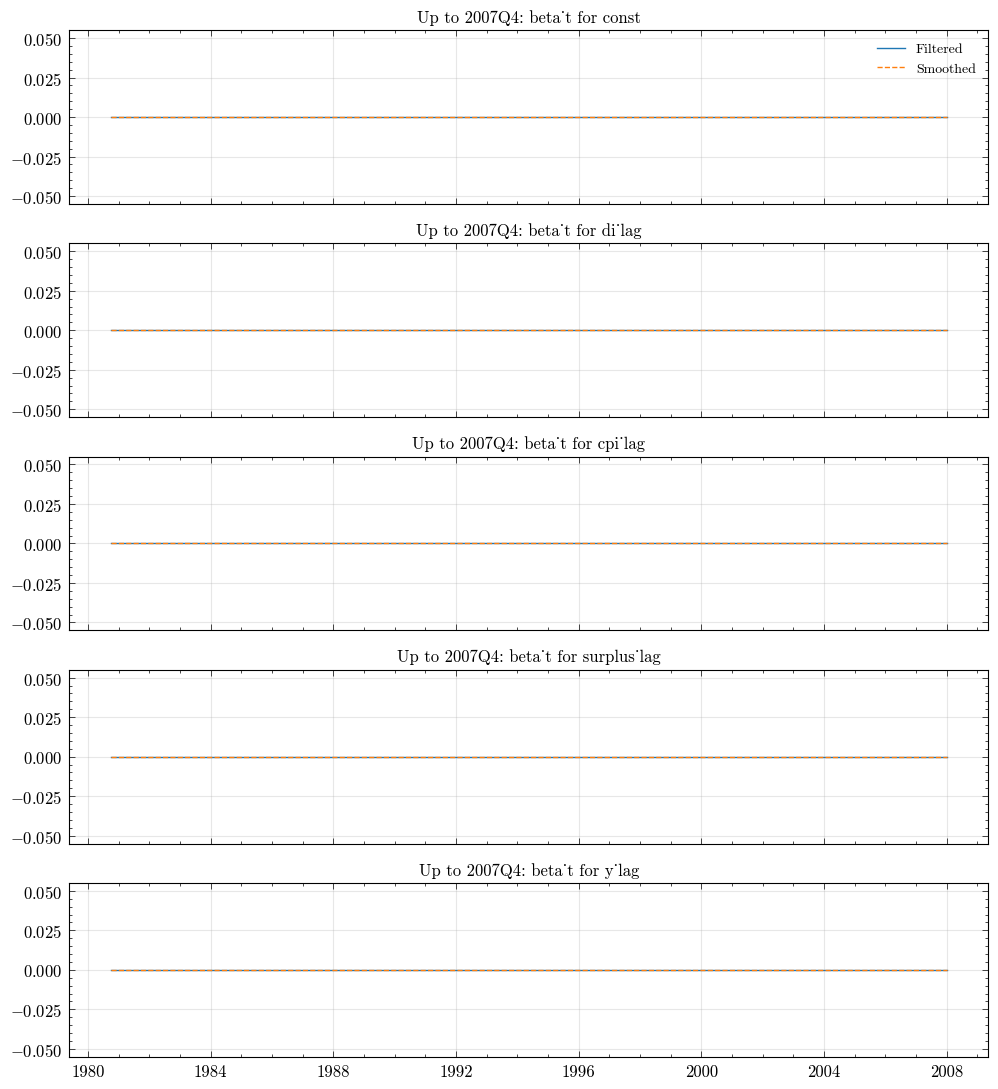

In [156]:
res_2007, beta_f_2007, beta_s_2007, (R_2007, Q_2007) = fit_and_plot(
    y_2007, X_2007, title_prefix="Up to 2007Q4:"
)